## Run the preprocessing pipeline

In [1]:
from preprocessing_pipeline import run_pipeline
from app.utils.rag_constants import *

input_file = f'gs://{BUCKET}/merged_datasets2.csv'
output_file = f'gs://{BUCKET}/clean_merge.json'

run_pipeline(input_file, output_file)

ModuleNotFoundError: No module named 'utils'

## Load the Knowledge Graph into neo4J

The following code loads the knowledge graph into neo4J.

Make sure neo4J desktop is currently open and the Neo4J database engine is currently running.

To connect to a different database, change NEO4J_URI, NEO4J_USERNAME, and NEO4J_PASSWORD in utils/rag_constants.py

In [10]:
from app.utils import print_debug
from app.utils import neo4j_client

ontology = "sample_data/e_commerce_website_pooja.owl"
csv_file = "sample_data/giftcard.csv" # MERGED_DATA = "merged_datasets2.csv"

kg_loader = neo4j_client.KnowledgeGraphLoader(ontology, csv_file)
kg_loader.load_knowledge_graph(reset=True) # this deletes the existing graph in neo4J and replaces it with the KG.

Ontology loaded from sample_data/e_commerce_website_pooja.owl: [a rdfg:Graph;rdflib:storage [a rdflib:Store;rdfs:label 'Memory']].
Connected to Neo4J instance at bolt://localhost:7687
Deleted existing graph; ready to load knowledge graph
Loaded 57 classes from sample_data/e_commerce_website_pooja.owl
Loaded products in 58 classes from sample_data/giftcard.csv
Done


### Build Additional Details with LLM and Cypher queries

In [ ]:
from app.llm_handler import get_model, prompt_llm

In [ ]:
PROMPT_CYPHER_WRITE= """
"Extract key points of the given item from its description (such as color, material(s), brand name, manufacturer, product line, or others) and edit the Cypher query below to add the key points to the graph. Return only the edited Cypher query.

User query:
{user_query}

Cypher query:
MATCH (n)
WHERE n.title = {item}
add new connection or create a new node with the property.
"""

In [ ]:
csv_file = "sample_data/giftcard.csv" 

## Girvan-Newman clustering algorithm

The following code runs Girvan-Newman on the neo4J graph.

On a large graph, this can take a very long time.

In [2]:
from girvan_newman import GirvanNewman

gn = GirvanNewman()

Connected to Neo4J instance at neo4j+s://508011ec.databases.neo4j.io
Running Girvan-Newman algorithm... This may take a while.
Finished running Girvan-Newman.


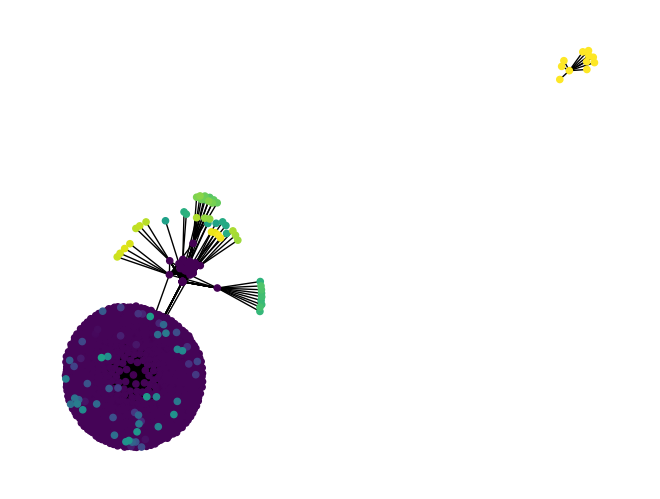

In [3]:
gn.draw_colored_graph(iteration=100)

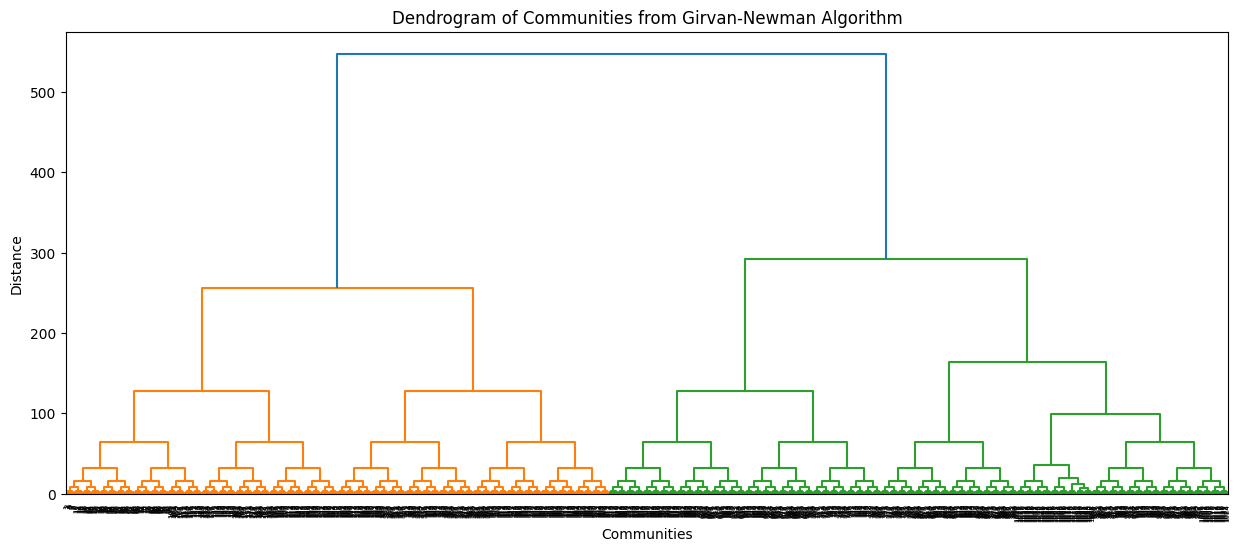

In [4]:
gn.draw_gn_dendrogram()

## Retrieve Nodes

In [1]:
from app.utils import neo4j_client

Q_FUZZY_MATCH = """
MATCH (n)
WHERE n.title STARTS WITH 'Pet'
RETURN n
"""
# or CONTAINS (performance hit)

driver = neo4j_client.get_driver()
r = neo4j_client.exec_query(driver,Q_FUZZY_MATCH)
print(r)

Connected to Neo4J instance at neo4j+s://508011ec.databases.neo4j.io
Query `
MATCH (n)
WHERE n.title STARTS WITH 'Pet'
RETURN n
` returned 4 records in 57 ms.
<Record n=<Node element_id='4:1761f531-f98e-4bec-b8ee-7ff7130ea5fb:84' labels=frozenset({'PetSmart Gift Card'}) properties={'features': "Gift cards are valid online and in store for merchandise, training, grooming, PetSmart PetsHotel and Doggie Day Camp.', 'Redemption: Instore and Online', 'No returns and no refunds on gift cards.'", 'images': "{'thumb': 'https://m.media-amazon.com/images/I/41CP7hgynoL. SX38 SY50 CR,0,0,38,50 .jpg', 'large': 'https://m.media-amazon.com/images/I/41CP7hgynoL.jpg', 'variant': 'MAIN', 'hi res': None}", 'price': 25.0, 'averageRating': 4.8, 'mainCategory': 'Gift Cards', 'description': "Gift cards make the perfect gift - letting the recipient choose exactly what they wish to purchase. Gift cards are valid online and in store for merchandise, training, grooming, PetSmart, PetsHotel and Doggie Day Camp.'"

In [2]:
print(r[0])

<Record n=<Node element_id='4:1761f531-f98e-4bec-b8ee-7ff7130ea5fb:84' labels=frozenset({'PetSmart Gift Card'}) properties={'features': "Gift cards are valid online and in store for merchandise, training, grooming, PetSmart PetsHotel and Doggie Day Camp.', 'Redemption: Instore and Online', 'No returns and no refunds on gift cards.'", 'images': "{'thumb': 'https://m.media-amazon.com/images/I/41CP7hgynoL. SX38 SY50 CR,0,0,38,50 .jpg', 'large': 'https://m.media-amazon.com/images/I/41CP7hgynoL.jpg', 'variant': 'MAIN', 'hi res': None}", 'price': 25.0, 'averageRating': 4.8, 'mainCategory': 'Gift Cards', 'description': "Gift cards make the perfect gift - letting the recipient choose exactly what they wish to purchase. Gift cards are valid online and in store for merchandise, training, grooming, PetSmart, PetsHotel and Doggie Day Camp.'", 'ratingNumber': 1990, 'store': 'Petsmart', 'categories': "Gift Cards', 'Gift Card Categories', 'Specialty Cards'", 'title': 'PetSmart Gift Card', 'parent asi

In [3]:
r[0].get('exists')

In [ ]:
r = neo4j_client.exec_query(driver,Q_FUZZY_MATCH)
print(r)

## RAG

In [1]:
from app.llm_handler import LLMHandler, AvailableLLMs

prompt = "I am looking for a gift card suitable as a birthday gift for a writer."
llm_handler = LLMHandler(AvailableLLMs.GEMINI)
llm_handler.get_llm_response(prompt)

Connected to Neo4J instance at bolt://localhost:7687
Prompt for cypher:

Given the user query please construct a cypher query to retrieve from the database related entries. Only respond with the Cypher query, and limit the responses to 10.

The valid mainCategory values to filter on are:
dict_values(['Gift Cards', 'All Beauty', 'AMAZON FASHION', 'Amazon Home', '', 'Arts, Crafts & Sewing', '', '', '', '', '', '', '', '', 'All Electronics', 'Grocery', '', '', 'Health & Personal Care', '', '', '', '', '', '', 'Office Products', '', '', 'Software', 'Sports & Outdoors', '', '', 'Toys & Games', 'Video Games', 'Unknown'])

User query:
I am looking for a gift card suitable as a birthday gift for a writer.

Cypher response: candidates {
  content {
    role: "model"
    parts {
      text: "MATCH (n:Product) WHERE n.mainCategory = \'Gift Cards\' RETURN n\n```\n"
    }
  }
  avg_logprobs: -0.040500731695265996
  finish_reason: STOP
}
model_version: "gemini-1.5-flash-002"
usage_metadata {
  promp

'The best gift card for a writer depends on their specific needs and preferences, but here are some excellent options categorized by their usefulness:\n\n**For Research & Inspiration:**\n\n* **Amazon:**  A classic choice. They can buy books, research materials, writing software, and even stationery.\n* **Barnes & Noble:** Similar to Amazon, but focuses more on books and physical media.\n* **Bookshop.org:**  Supports independent bookstores while providing a wide selection of books.\n* **Masterclass:** Offers online courses taught by masters in various fields, potentially inspiring new ideas or improving skills.\n\n**For Practical Writing Tools & Services:**\n\n* **Grammarly Premium:** Subscription to a grammar and writing tool.\n* **ProWritingAid:** Another grammar and style checker.\n* **Scrivener:**  Popular writing software for organizing and writing long-form projects.\n* **Reedsy:** A platform connecting authors with editors, cover designers, and other professionals.\n\n**For Creat